# Predicción de demanda de alquileres sitycleta por países

### En este trabajo final del curso de Inteligencia Artificial y Big data que estamos trabajandom, vamos a realizar la predicion de numero de usuarios de "sitycleta" de la empresa de Sagulpa.

En este trabajo lo que se pretende llevar a cabo es la creacíon y manipulación de datos optenidos por la empresa Sagulpa en su paguina web 

### Aquí muestro todas las transforciones y modelos de entrenamiento que he utilizado para realizar el proyecto del

## Documentación

ID de cada Pais

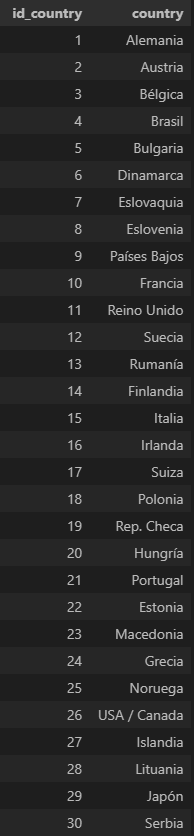

Nota: Regresion por paices saber cantidad de alquiler por paices, tranformar las estaciones de salida a numerico

# Inicio del Proyecto

In [65]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [66]:
df_clima = pd.read_csv('data/time_df.csv', sep=';')
df_clima

,prec,presMax,presMin,racha,tmax,tmed,tmin,velmedia,moth,day
0,3.10,1015.70,1012.00,11.40,22.30,20.60,19.00,2.80,12,1
1,1.10,1012.90,1008.80,7.80,23.00,20.70,18.40,3.30,12,2
2,7.10,1009.70,1006.50,6.70,20.10,18.90,17.70,1.70,12,3
3,0.00,1007.70,1004.90,3.90,23.00,20.10,17.20,1.10,12,4
4,0.40,1015.00,1006.10,6.90,24.20,22.00,19.90,1.40,12,5
5,0.00,1015.10,1010.90,3.60,24.90,21.70,18.50,0.30,12,6
6,0.80,1010.90,1005.60,3.30,22.70,20.80,19.00,1.10,12,7
7,0.00,1010.00,1005.70,4.70,23.70,22.00,20.20,0.60,12,8
8,0.00,1015.20,1009.20,6.10,25.00,22.40,19.90,0.80,12,9
9,0.00,1017.30,1014.10,5.00,24.80,22.40,20.00,0.80,12,10


In [67]:
df_sagulpa = pd.read_csv('data/sagulpa_df.csv', sep=';')
df_sagulpa

,id_country,country,start_place,start_day,start_month,start_h,start_min,start_seg,end_day,end_month,end_h,end_min,end_seg,user_time
0,18,Polonia,Plazoleta de Farray,13,12,20,59,23,14,12,8,6,9,11:06:46
1,20,Hungría,C.C. El Muelle,2,12,12,51,2,2,12,21,54,10,09:03:08
2,14,Finlandia,Plaza de España (elect.),27,12,11,12,16,27,12,19,50,51,08:38:35
3,11,Reino Unido,Teatro Pérez Galdós,27,12,22,18,4,28,12,6,37,52,08:19:48
4,11,Reino Unido,Churruca,30,12,22,29,17,31,12,6,47,42,08:18:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,18,Polonia,San Telmo,28,12,14,37,34,28,12,14,38,28,00:00:54
4280,15,Italia,Plaza de la feria,13,12,11,46,49,13,12,11,47,38,00:00:49
4281,11,Reino Unido,Plazoleta de Farray,4,12,21,8,3,4,12,21,8,49,00:00:46
4282,14,Finlandia,Plaza de la feria,1,12,9,11,42,1,12,9,12,27,00:00:45


In [68]:
# Renombrar las columnas
nuevos_nombres = {' tmed': 'tmed', ' tmin': 'tmin', ' velmedia': 'velmedia'}
df_clima = df_clima.rename(columns=nuevos_nombres)

for index, row in df_sagulpa.iterrows():
    match = df_clima[(df_clima['day'] == row['start_day'])]
    if not match.empty:
        df_sagulpa.loc[index, 'prec'] = match.iloc[0]['prec']
        df_sagulpa.loc[index, 'presMax'] = match.iloc[0]['presMax']
        df_sagulpa.loc[index, 'presMin'] = match.iloc[0]['presMin']
        df_sagulpa.loc[index, 'tmax'] = match.iloc[0]['tmax']
        df_sagulpa.loc[index, 'tmed'] = match.iloc[0]['tmed']
        df_sagulpa.loc[index, 'tmin'] = match.iloc[0]['tmin']
        df_sagulpa.loc[index, 'velmedia'] = match.iloc[0]['velmedia']

## Eliminamos columnas para preparar el DF_final

In [69]:
colum_delete = ['start_month','start_min', 'start_h', 'start_seg', 'end_day', 'end_month', 'end_h', 'end_min', 'end_seg', 'user_time', 'country']
df_final = df_sagulpa.drop(columns=colum_delete)
df_final

,id_country,start_place,start_day,prec,presMax,presMin,tmax,tmed,tmin,velmedia
0,18,Plazoleta de Farray,13,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10
1,20,C.C. El Muelle,2,1.10,1012.90,1008.80,23.00,20.70,18.40,3.30
2,14,Plaza de España (elect.),27,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70
3,11,Teatro Pérez Galdós,27,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70
4,11,Churruca,30,0.00,1022.10,1019.50,24.90,22.50,20.10,1.90
...,...,...,...,...,...,...,...,...,...,...
4279,18,San Telmo,28,0.00,1020.60,1018.10,23.20,21.80,20.50,1.10
4280,15,Plaza de la feria,13,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10
4281,11,Plazoleta de Farray,4,0.00,1007.70,1004.90,23.00,20.10,17.20,1.10
4282,14,Plaza de la feria,1,3.10,1015.70,1012.00,22.30,20.60,19.00,2.80


In [70]:
# Contar el número de cogidas de bicicletas por base y dia
word = df_final.groupby(['start_place','start_day']).size().reset_index(name='catch_for_day')

# hacemos una muestra buscando por el nombre de una base
word[word['start_place'] == 'C.C. El Muelle']

,start_place,start_day,catch_for_day
83,C.C. El Muelle,1,3
84,C.C. El Muelle,2,5
85,C.C. El Muelle,3,1
86,C.C. El Muelle,4,5
87,C.C. El Muelle,5,6
88,C.C. El Muelle,6,6
89,C.C. El Muelle,7,4
90,C.C. El Muelle,8,5
91,C.C. El Muelle,10,7
92,C.C. El Muelle,11,12


In [71]:
# Realizar la fusión basada en la columna 'start_place' y 'start_day'
df_final = df_final.merge(word, on=['start_place', 'start_day'], how='left')

# Obtener los códigos numéricos y los valores únicos correspondientes
codes, unique_values = pd.factorize(df_final['start_place'])

# Agregar una nueva columna con los códigos numéricos
df_final['id_place'] = codes

# eliminamos la columna string de nombres de base
df_final = df_final.drop('start_place', axis=1)

# renombrar el nombre de las columnas
df_final.rename(columns={'start_day': 'day'}, inplace=True)

# mostramos el df
df_final 

,id_country,day,prec,presMax,presMin,tmax,tmed,tmin,velmedia,catch_for_day,id_place
0,18,13,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10,9,0
1,20,2,1.10,1012.90,1008.80,23.00,20.70,18.40,3.30,5,1
2,14,27,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70,8,2
3,11,27,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70,6,3
4,11,30,0.00,1022.10,1019.50,24.90,22.50,20.10,1.90,13,4
...,...,...,...,...,...,...,...,...,...,...,...
4279,18,28,0.00,1020.60,1018.10,23.20,21.80,20.50,1.10,16,15
4280,15,13,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10,5,9
4281,11,4,0.00,1007.70,1004.90,23.00,20.10,17.20,1.10,13,0
4282,14,1,3.10,1015.70,1012.00,22.30,20.60,19.00,2.80,7,9


[Text(0.5, 0, 'id_country'),
 Text(1.5, 0, 'day'),
 Text(2.5, 0, 'prec'),
 Text(3.5, 0, 'presMax'),
 Text(4.5, 0, 'presMin'),
 Text(5.5, 0, 'tmax'),
 Text(6.5, 0, 'tmed'),
 Text(7.5, 0, 'tmin'),
 Text(8.5, 0, 'velmedia'),
 Text(9.5, 0, 'catch_for_day'),
 Text(10.5, 0, 'id_place')]

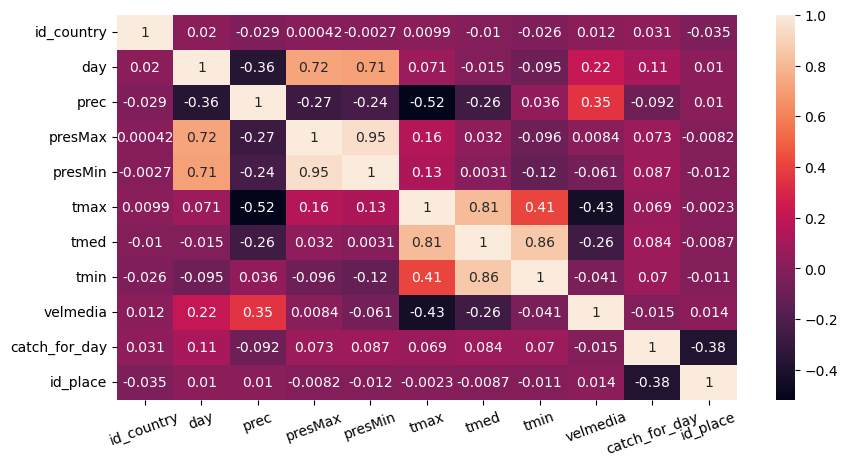

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.heatmap(df_final.corr(), annot=True)

# Ajustar las etiquetas del eje x en horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

## Entrenamiento del modelo

### Segundo realizamos con el LazyPredict un estudio rapido sobre que modelos nos puede servir para el entrenamiento

In [74]:
# # Estandarización de características numéricas
# scaler = StandardScaler().fit(x_train)
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

# # Inicialización de LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

# # Entrenamiento y evaluación de los modelos
# models, predictions = reg.fit(x_train, x_test, y_train, y_test)

# # Imprimir los modelos
# models

### Primero vamos a separar los datos

In [73]:
# Dividimos los datos de entrenamiento
X_Train  = df_final.drop(['catch_for_day'], axis=1)
Y_Train  = df_final['catch_for_day']

In [ ]:
l_estimators = [2, 4, 8, 16, 32]
regressor = RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)

In [ ]:
l_estimators = [2, 4, 8, 16, 32]

cv = TimeSeriesSplit(n_splits = 10)

# reseteamos el index con el fin de evitar problemas en la validación cruzada
Train.reset_index(drop=True,inplace=True)

total_scores = []
for estimators in l_estimators:
    fold_accuracy = []
    regressor = RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(Train):
      # División train test aleatoria
      f_train = Train.loc[train_fold]
      f_test = Train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit(Train, Test)
      Y_Pred = regressor.predict(Test)
      # evaluación del modelo
      mae = mean_absolute_error(Test,Y_Pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"% (best_est, best_mae))

In [ ]:
# Calcular la puntuación del modelo
score = regressor.score(Train, Test)
print("Puntuación del modelo: {:.2f}".format(score))

In [ ]:
model = regressor.fit(x_train, y_train)

In [ ]:
# df_final.to_csv('result/sagulpa.csv', index=False)